# Support Vector Machine com RFECV

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

Tratamento da Random Seed

In [2]:
def set_seed(seed: int):
    random.seed(seed) # Python
    np.random.seed(seed)  # Numpy, é o gerador utilizado pelo sklearn
    os.environ["PYTHONHASHSEED"] = str(seed)  # sistema operativo

# Fixar a seed
set_seed(2023)

Load CSVs

In [3]:
df_train = pd.read_csv('../../datasets_manuseados/train_radiomics_hipocamp_treated.csv')
df_test = pd.read_csv('../../datasets_manuseados/test_radiomics_hipocamp_treated.csv')

Float64/Int64 to Float32/Int32

In [4]:
float_features = df_train.select_dtypes(include='float')
int_features = df_train.select_dtypes(include='int')
df_train[float_features.columns] = df_train[float_features.columns].astype(np.float32)
df_train[int_features.columns] = df_train[int_features.columns].astype(np.int32)
df_train.info()
print("--------------------")
float_features = df_test.select_dtypes(include='float')
int_features = df_test.select_dtypes(include='int')
df_test[float_features.columns] = df_test[float_features.columns].astype(np.float32)
df_test[int_features.columns] = df_test[int_features.columns].astype(np.int32)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Columns: 1903 entries, RowId to Transition
dtypes: float32(1901), int32(1), object(1)
memory usage: 2.2+ MB
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 1902 entries, RowId to Age
dtypes: float32(1901), int32(1)
memory usage: 743.1 KB


Train Test Split

In [5]:
X = df_train.drop(columns=['Transition'])
y = df_train['Transition']

X_test = df_test

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2023, stratify = y)

Feature Selection using RFECV and PCA

Fitting estimator with 1902 features.
Fitting estimator with 1902 features.
Fitting estimator with 1902 features.
Fitting estimator with 1901 features.
Fitting estimator with 1901 features.
Fitting estimator with 1901 features.
Fitting estimator with 1900 features.
Fitting estimator with 1900 features.
Fitting estimator with 1900 features.
Fitting estimator with 1899 features.
Fitting estimator with 1899 features.
Fitting estimator with 1899 features.
Fitting estimator with 1898 features.
Fitting estimator with 1898 features.
Fitting estimator with 1898 features.
Fitting estimator with 1897 features.
Fitting estimator with 1897 features.
Fitting estimator with 1897 features.
Fitting estimator with 1896 features.
Fitting estimator with 1896 features.
Fitting estimator with 1896 features.
Fitting estimator with 1895 features.
Fitting estimator with 1895 features.
Fitting estimator with 1895 features.
Fitting estimator with 1894 features.
Fitting estimator with 1894 features.
Fitting esti

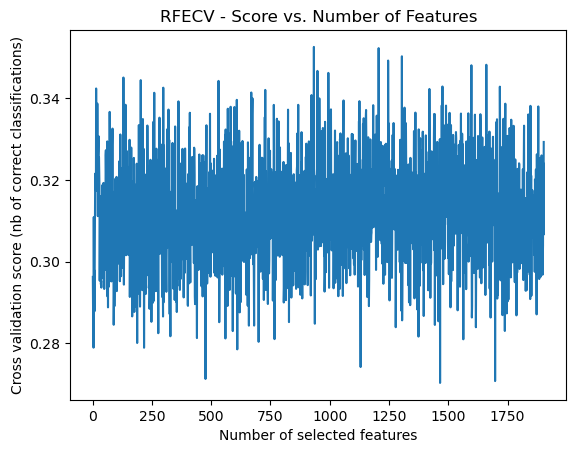

Original number of features (after RFECV): 933
Number of components selected by PCA: 89


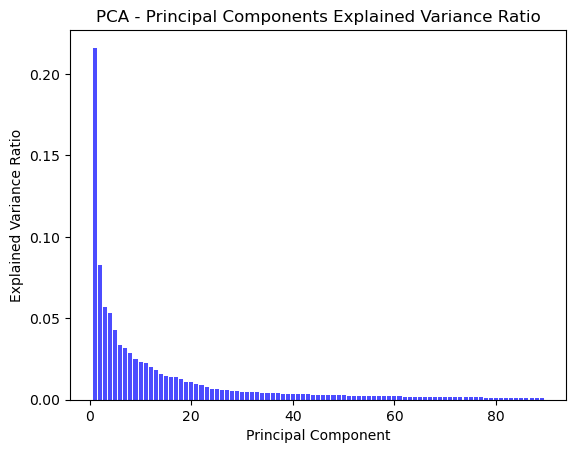

Final shape of the train dataset: (305, 89)
Final shape of the test dataset: (100, 89)
Final shape of the training part of the train dataset: (244, 89)
Final shape of the testing part of the train dataset: (61, 89)


In [6]:
model = RandomForestClassifier(random_state=2023)

### 1. RFECV - Recursive Feature Elimination with Cross-Validation
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(3), scoring='f1_macro', n_jobs=-1, verbose=2)
rfecv.fit(X, y)

rfecv_features = X.columns[rfecv.support_]
print(f"Number of selected features by RFECV: {len(rfecv_features)}")
print(f"Eliminated features by RFECV: {len(X.columns) - len(rfecv_features)}")

plt.figure()
plt.xlabel("Number of selected features")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title("RFECV - Score vs. Number of Features")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

X_rfecv = X[rfecv_features]
X_test_rfecv = X_test[rfecv_features]
X_train_rfecv = X_train[rfecv_features]
X_val_rfecv = X_val[rfecv_features]

### 2. PCA - Principal Component Analysis
pca = PCA(n_components=0.95)
X_final = pca.fit_transform(X_rfecv)
X_test_final = pca.transform(X_test_rfecv)
X_train_final = pca.transform(X_train_rfecv)
X_val_final = pca.transform(X_val_rfecv)
print(f"Original number of features (after RFECV): {X_rfecv.shape[1]}")
print(f"Number of components selected by PCA: {pca.n_components_}")

plt.figure()
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, color='blue', alpha=0.7)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA - Principal Components Explained Variance Ratio")
plt.show()

# Final datasets for training and testing
print(f"Final shape of the train dataset: {X_final.shape}")
print(f"Final shape of the test dataset: {X_test_final.shape}")
print(f"Final shape of the training part of the train dataset: {X_train_final.shape}")
print(f"Final shape of the testing part of the train dataset: {X_val_final.shape}")

## Grid Search

Fitting 3 folds for each of 14112 candidates, totalling 42336 fits
[CV 1/3] END C=0.01, class_weight=None, coef0=0.0, decision_function_shape=ovo, degree=2, gamma=0.01, kernel=linear, probability=False, shrinking=True, tol=0.001;, score=0.289 total time=   0.0s
[CV 2/3] END C=0.01, class_weight=None, coef0=0.0, decision_function_shape=ovo, degree=2, gamma=0.01, kernel=linear, probability=False, shrinking=True, tol=0.001;, score=0.303 total time=   0.0s
[CV 3/3] END C=0.01, class_weight=None, coef0=0.0, decision_function_shape=ovo, degree=2, gamma=0.01, kernel=linear, probability=False, shrinking=True, tol=0.001;, score=0.296 total time=   0.0s
[CV 1/3] END C=0.01, class_weight=None, coef0=0.0, decision_function_shape=ovo, degree=2, gamma=0.01, kernel=linear, probability=False, shrinking=True, tol=0.0001;, score=0.289 total time=   0.0s
[CV 2/3] END C=0.01, class_weight=None, coef0=0.0, decision_function_shape=ovo, degree=2, gamma=0.01, kernel=linear, probability=False, shrinking=True, 

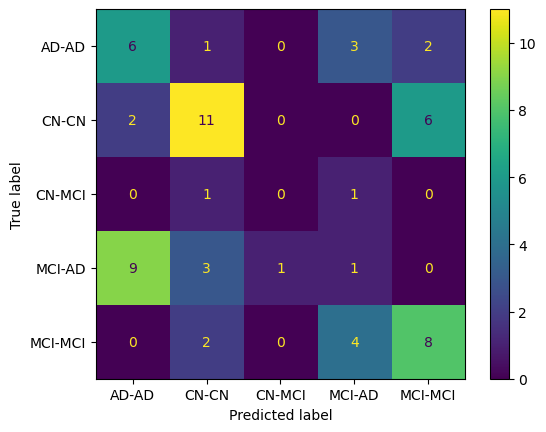

In [15]:
svc = SVC(random_state=2023)

param_grid = {
    'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'gamma': [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'kernel': ['linear','poly', 'rbf', 'sigmoid'],
    'degree': [2,3,4],  # Only relevant for 'poly' kernel
    'coef0': [0.0, 0.5, 1],  # For 'poly' and 'sigmoid' kernels
    'shrinking': [True],  # Shrinking generally speeds up convergence
    'probability': [False], # Disabling to speed up training
    'class_weight': [None, 'balanced'], # Important for imbalanced datasets
    'decision_function_shape': ['ovo', 'ovr'],  # For multi-class classification
    'tol': [1e-3, 1e-4], # Tolerance for stopping criterion
}

grid_searchSVC = GridSearchCV(svc, param_grid, cv=3, refit=True, verbose=3, scoring = 'f1_macro')
grid_searchSVC.fit(X_train_final, y_train)
grid_predictionSVC = grid_searchSVC.predict(X_val_final)

print("Best estimator: ", grid_searchSVC.best_estimator_)

print(classification_report(y_val, grid_predictionSVC))
ConfusionMatrixDisplay.from_predictions(y_val, grid_predictionSVC)
plt.show()

## Support Vector Machine

In [20]:
svc = SVC(C=1, class_weight='balanced', decision_function_shape='ovo', degree=2, gamma=0.01, kernel='linear', random_state=2023)

svc.fit(X_final, y)
predictionSVC = svc.predict(X_test_final)

In [21]:
with open('../../predictions/svc.csv', 'w') as results:
    results.write('RowId,Result\n')
    i = 1
    for p in predictionSVC:
        results.write(f'{i},{p}\n')
        i+=1